# Assignment 1

Deadline: 19.03.2025, 12:00 CET

<Ishaan Bhondele, 23-745-862 and emal address>

In [1]:
# Import standard libraries
import os
import sys
import timeit # To compute runtimes
from typing import Optional

# Import third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import local modules
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   # Change this path if needed
src_path = os.path.join(project_root, 'qpmwp-course\\src')
sys.path.append(project_root)
sys.path.append(src_path)
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.constraints import Constraints
from optimization.optimization import Optimization, Objective
from optimization.optimization_data import OptimizationData
from optimization.quadratic_program import QuadraticProgram, USABLE_SOLVERS

## 1. Solver Horse Race

### 1.a)
(3 points)

Generate a Multivariate-Normal random dataset of dimension TxN, T=1000, N=100, and compute a vector of expected returns, q, and a covariance matrix, P, using classes ExpectedReturn and Covariance respectively.

In [2]:

# Set the dimensions
T = 1000  # Number of time periods
N = 100   # Number of assets

#Generate a random mean vector and covariance matrix for the multivariate normal distribution
mean = np.random.rand(N)
A = np.random.rand(N, N)
cov = np.dot(A, A.T) #ensure PSD

# Generate the Multivariate-Normal random dataset
data = np.random.multivariate_normal(mean, cov, T)

# Convert the dataset to a DataFrame for easier manipulation
data_df = pd.DataFrame(data, columns=[f'Asset_{i+1}' for i in range(N)])

# Compute the vector of expected returns (mean returns) from df
expected_return = ExpectedReturn()
expected_return.estimate(X=data_df)
q = expected_return.vector
# Compute the covariance matrix from df
covariance = Covariance()
covariance.estimate(X=data_df)

P = covariance.matrix

# Display the results
print("Vector of expected returns (q):")
print(q)

print("\nCovariance matrix (P):")
print(P)

Vector of expected returns (q):
Asset_1      2.429749
Asset_2      2.435888
Asset_3      2.466125
Asset_4      2.679035
Asset_5      2.414669
               ...   
Asset_96     2.755101
Asset_97     2.673961
Asset_98     2.195614
Asset_99     2.621180
Asset_100    2.851160
Length: 100, dtype: float64

Covariance matrix (P):
             Asset_1    Asset_2    Asset_3    Asset_4    Asset_5    Asset_6  \
Asset_1    29.277001  21.819688  23.245070  23.425166  24.265357  20.773538   
Asset_2    21.819688  30.510820  23.513892  23.186882  25.163547  23.223329   
Asset_3    23.245070  23.513892  29.866398  26.028789  25.450915  21.628002   
Asset_4    23.425166  23.186882  26.028789  35.312884  25.471631  23.204784   
Asset_5    24.265357  25.163547  25.450915  25.471631  35.570137  23.460152   
...              ...        ...        ...        ...        ...        ...   
Asset_96   24.247934  25.589512  26.599532  28.377886  28.617708  25.863351   
Asset_97   23.637903  23.244197  22.873365

c:\Users\IAB\OneDrive\CODE\QPMP\Assignment_1\qpmwp-course\.venv\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


### 1.b)
(3 points)

Instantiate a constraints object by injecting column names of the data created in 1.a) as ids and add:
- a budget constaint (i.e., asset weights have to sum to one)
- lower bounds of 0.0 for all assets
- upper bounds of 0.2 for all assets
- group contraints such that the sum of the weights of the first 30 assets is <= 0.3, the sum of assets 31 to 60 is <= 0.4 and the sum of assets 61 to 100 is <= 0.5

In [3]:
# Instantiate the Constraints class
constraints = Constraints(ids = data_df.columns.tolist())

# Add budget constraint
constraints.add_budget(rhs=1.0)

# Add box constraints (i.e., lower and upper bounds)
constraints.add_box(lower=0.0, upper=0.2)

# Add linear constraints
group1_ids = data_df.columns[:30]
g1 = pd.Series(np.ones(len(group1_ids)), index=group1_ids)
constraints.add_linear(g_values=g1, sense="<=", rhs=0.3, name="group1")

# For the second group (assets 31 to 60)
group2_ids = data_df.columns[30:60]
g2 = pd.Series(np.ones(len(group2_ids)), index=group2_ids)
constraints.add_linear(g_values=g2, sense="<=", rhs=0.4, name="group2")

# For the third group (assets 61 to 100)
group3_ids = data_df.columns[60:]
g3 = pd.Series(np.ones(len(group3_ids)), index=group3_ids)
constraints.add_linear(g_values=g3, sense="<=", rhs=0.5, name="group3")

### 1.c) 
(4 points)

Solve a Mean-Variance optimization problem (using coefficients P and q in the objective function) which satisfies the above defined constraints.
Repeat the task for all open-source solvers in qpsolvers and compare the results in terms of:

- runtime
- accuracy: value of the primal problem.
- reliability: are all constarints fulfilled? Extract primal resisduals, dual residuals and duality gap.

Generate a DataFrame with the solvers as column names and the following row index: 'solution_found': bool, 'objective': float, 'primal_residual': float, 'dual_residual': float, 'duality_gap': float, 'runtime': float.

Put NA's for solvers that failed for some reason (e.g., unable to install the package or solvers throws an error during execution). 




In [4]:

import time
import qpsolvers
from qpsolvers import Problem, solve_problem
from scipy.sparse import csc_matrix

# Extract the constraints in the format required by the solver

GhAb = constraints.to_GhAb()

# Loop over solvers, instantiate the quadratic program, solve it and store the results
# Get the lower and upper bounds from the box constraints
lb = constraints.box['lower'].to_numpy() if constraints.box['lower'] is not None else None
ub = constraints.box['upper'].to_numpy() if constraints.box['upper'] is not None else None

# converted to csc matrix--> Array: so I can get a value for the solvers that don't support sparse matrices
# Can use CSC matrix [remove .toarray()] to get better calculated solver values (ignore/nan the ones that don't support sparse matrices) 
P_sparse = csc_matrix(P)
G_sparse = csc_matrix(GhAb['G'])
A_sparse = csc_matrix(GhAb['A'])

q = q.to_numpy()
b = np.reshape(GhAb['b'], (1,))

#Define a list with the parameters for Quadratic Problem.
test_a = {'P': P_sparse, 'q':q, 'G':G_sparse, 'h':GhAb['h'], 'A':A_sparse, 'b':b, 'lb':lb, 'ub':ub}

# for var in test_a.keys():
#     print(type(test_a[var]))

#     print("\n")



In [5]:
#Using class QuadraticProgram (converted to csc matrix)
results_test = {}
for solver in qpsolvers.available_solvers:
    try:
        qp = QuadraticProgram(test_a['P'], test_a['q'],
        G=test_a['G'], h=test_a['h'],
        A=test_a['A'], b=test_a['b'],
        lb=test_a['lb'], ub=test_a['ub'],
        solver=solver)
        qp.solve()
        # Save the solution (or objective, diagnostics, etc.) for later analysis.
        results_test[solver] = qp.results.get('solution')
    except Exception as e:
        # If an error occurs (or the solver fails), store None (or np.nan) for that solver.
        results_test[solver] = None

# Convert the results to a PD DF
import pandas as pd
results_test_df = pd.DataFrame([
    {'solver': solver, 'solution_found': (sol is not None and sol.found) if sol is not None else False,
     'objective': (
         0.5 * np.dot(sol.x, P.dot(sol.x)) + np.dot(q, sol.x)
         if sol is not None and sol.found else np.nan)
    }
    for solver, sol in results_test.items()
])
print(results_test_df)


     solver  solution_found  objective
0  clarabel           False        NaN
1    cvxopt            True  11.965384
2      daqp           False        NaN
3      ecos           False        NaN
4     highs            True  11.965384
5      osqp            True  11.835559
6     qpalm            True  11.965269
7  quadprog           False        NaN
8       scs           False        NaN
9      qpax           False        NaN


In [6]:
# Create the Problem instance.
problem = Problem(
    test_a['P'], test_a['q'],
    G=test_a['G'], h=test_a['h'],
    A=test_a['A'], b=test_a['b'],
    lb=test_a['lb'], ub=test_a['ub']
)

# List of solver names.
solver_names = [
    'clarabel',
    'cvxopt',
    'daqp',
    'ecos',
    'highs',
    'qpalm',
    'quadprog',
    'scs',
    'qpax'
]    # 'osqp' not included 

results = []  # List to store results for each solver.

for solver in solver_names:
    try:
        start_time = time.time()
        # Call the generic solver function with the solver name.
        solution = solve_problem(problem, solver=solver)
        runtime = time.time() - start_time

        if solution is not None and solution.found:
            x = solution.x
            # Compute objective: 0.5 * x^T P x + q^T x
            obj_val = 0.5 * np.dot(x, test_a['P'].dot(x)) + np.dot(test_a['q'], x)
            # Retrieve diagnostics by calling the method if necessary.
            primal_res = solution.primal_residual() if callable(solution.primal_residual) else solution.primal_residual
            dual_res = solution.dual_residual() if callable(solution.dual_residual) else solution.dual_residual
            dual_gap = solution.duality_gap() if callable(solution.duality_gap) else solution.duality_gap

            result = {
                'solver': solver,
                'solution_found': True,
                'objective': obj_val,
                'primal_residual': primal_res,
                'dual_residual': dual_res,
                'duality_gap': dual_gap,
                'runtime': runtime
            }
        else:
            result = {
                'solver': solver,
                'solution_found': False,
                'objective': np.nan,
                'primal_residual': np.nan,
                'dual_residual': np.nan,
                'duality_gap': np.nan,
                'runtime': runtime
            }
    except Exception as e:
        runtime = time.time() - start_time
        result = {
            'solver': solver,
            'solution_found': False,
            'objective': np.nan,
            'primal_residual': np.nan,
            'dual_residual': np.nan,
            'duality_gap': np.nan,
            'runtime': runtime
        }
    results.append(result)

# Combine all results into a single DataFrame.
results_df = pd.DataFrame(results)
print(results_df)


     solver  solution_found  objective  primal_residual  dual_residual  \
0  clarabel            True  11.965384     2.220446e-16   3.419487e-11   
1    cvxopt            True  11.965384     2.220446e-16   1.525535e-10   
2      daqp           False        NaN              NaN            NaN   
3      ecos           False        NaN              NaN            NaN   
4     highs            True  11.965384     0.000000e+00   1.999999e-08   
5     qpalm            True  11.965269     9.077530e-06   1.179496e-10   
6  quadprog           False        NaN              NaN            NaN   
7       scs            True  11.965387     3.287439e-06   3.523155e-05   
8      qpax            True  11.966365     1.788242e-07   8.106232e-06   

    duality_gap   runtime  
0           0.0  0.006869  
1      0.000002  0.029676  
2           NaN  0.000105  
3           NaN  0.000826  
4           0.0  0.002278  
5      0.000115  0.004240  
6           NaN  0.001364  
7      0.000001  0.003340  
8  0.00

Print and visualize the results

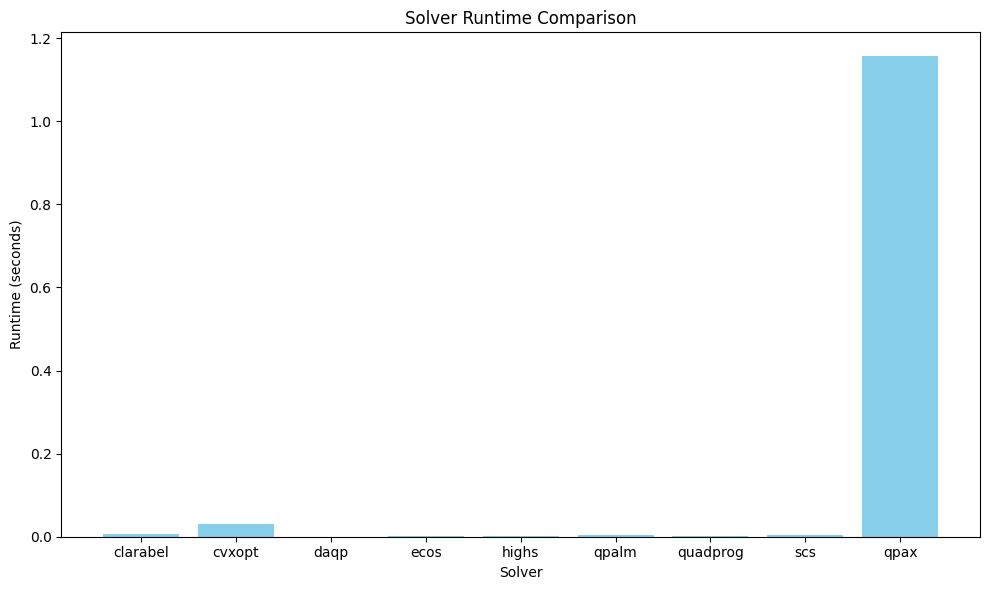

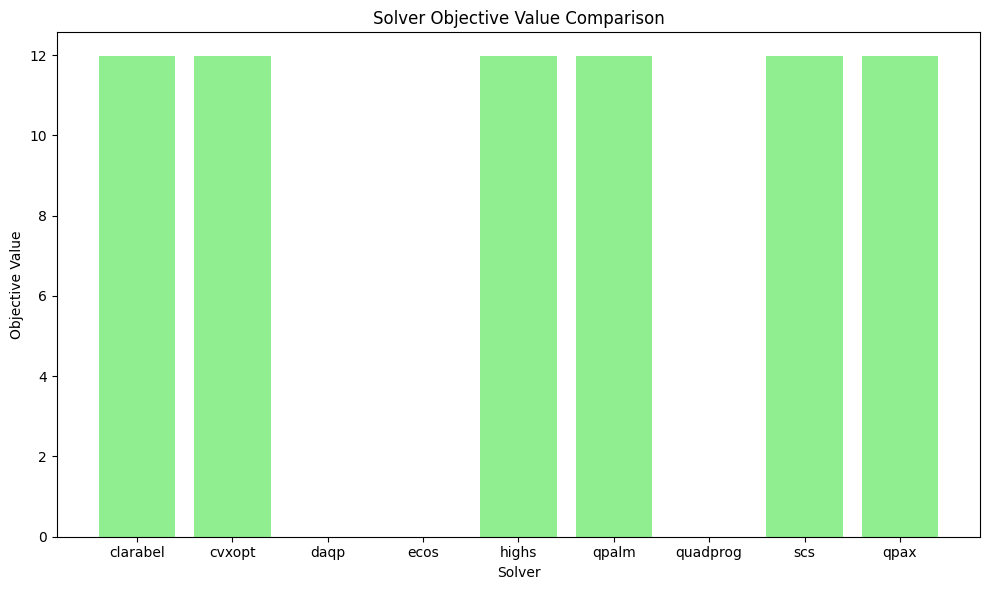

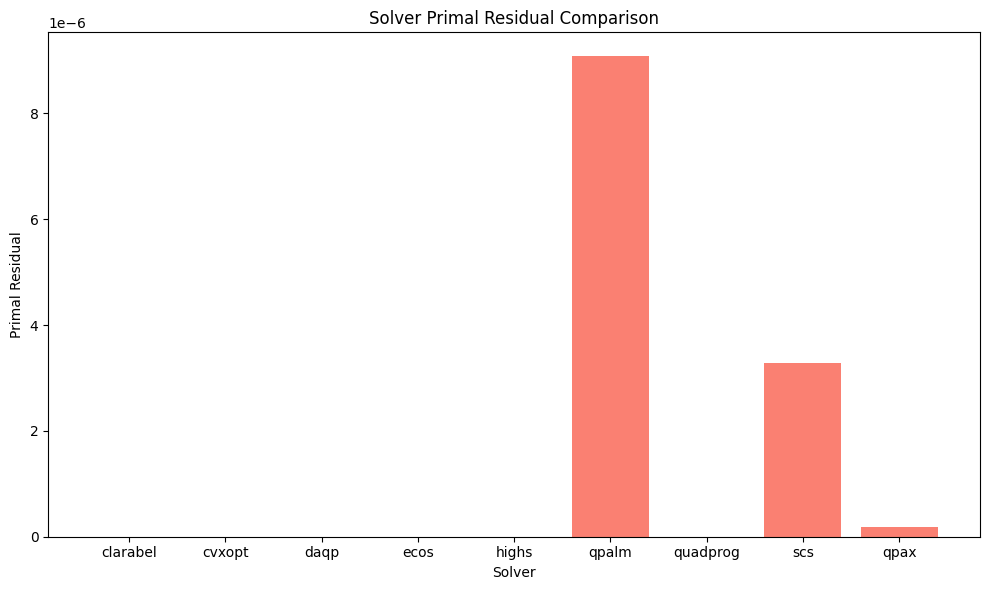

In [7]:

# Runtime Comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df['solver'], results_df['runtime'], color='skyblue')
plt.title("Solver Runtime Comparison")
plt.xlabel("Solver")
plt.ylabel("Runtime (seconds)")
plt.tight_layout()
plt.show()

# Objective Value Comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df['solver'], results_df['objective'], color='lightgreen')
plt.title("Solver Objective Value Comparison")
plt.xlabel("Solver")
plt.ylabel("Objective Value")
plt.tight_layout()
plt.show()

# Primal Residual Comparison (if available)
plt.figure(figsize=(10, 6))
plt.bar(results_df['solver'], results_df['primal_residual'], color='salmon')
plt.title("Solver Primal Residual Comparison")
plt.xlabel("Solver")
plt.ylabel("Primal Residual")
plt.tight_layout()
plt.show()


## 2. Analytical Solution to Minimum-Variance Problem

(5 points)

- Create a `MinVariance` class that follows the structure of the `MeanVariance` class.
- Implement the `solve` method in `MinVariance` such that if `solver_name = 'analytical'`, the analytical solution is computed and stored within the object (if such a solution exists). If not, call the `solve` method from the parent class.
- Create a `Constraints` object by injecting the same ids as in part 1.b) and add a budget constraint.
- Instantiate a `MinVariance` object by setting `solver_name = 'analytical'` and passing instances of `Constraints` and `Covariance` as arguments.
- Create an `OptimizationData` object that contains an element `return_series`, which consists of the synthetic data generated in part 1.a).
- Solve the optimization problem using the created `MinVariance` object and compare the results to those obtained in part 1.c).


In [8]:
# Define class MinVariance
class MinVariance(Optimization):

    def __init__(self,
                 constraints: Constraints,
                 covariance: Optional[Covariance] = None,
                 **kwargs):
        super().__init__(
            constraints=constraints,
            **kwargs
        )
        self.covariance = Covariance() if covariance is None else covariance

    def set_objective(self, optimization_data: OptimizationData) -> None:
        Sigma = self.covariance.matrix
        n = Sigma.shape[0]
        self.objective.coefficients = {
            'P': Sigma,
            'q': np.zeros(n),
            'constant': 0
        }

    def solve(self) -> None:
        if self.params.get('solver_name') == 'analytical':
            Sigma = self.covariance.matrix
            try:
                inv_Sigma = np.linalg.inv(Sigma)
            except np.linalg.LinAlgError:
                print("Covariance matrix is singular. Cannot compute analytical solution.")
                self.results['solution'] = {'weights': None, 'found': False}
                return None
            ones = np.ones(Sigma.shape[0])
            weights = inv_Sigma @ ones
            weights /= (ones.T @ inv_Sigma @ ones)
            # Store the solution in results as a dictionary of weights by asset id.
            self.results['solution'] = {
                'weights': dict(zip(self.constraints.ids, weights)),
                'found': True
            }
            print("Analytical solution computed.")
            return None
        else:
            return super().solve()


# Create a constraints object with just a budget constraint
constraints_analytical = Constraints(ids=data_df.columns.tolist())
constraints.add_budget(rhs=1.0)

# Instantiate the MinVariance class
minvar = MinVariance(constraints=constraints, covariance=covariance, solver_name='analytical')

# Prepare the optimization data and prepare the optimization problem

expected_return_minivar = ExpectedReturn()
expected_return_minivar.estimate(X=data_df)
return_series = expected_return_minivar.vector
opt_data = OptimizationData(return_series=return_series)

# Solve the optimization problem and print the weights
# Set the objective of the MinVariance instance using the OptimizationData.
minvar.set_objective(opt_data)

# Solve the problem 
minvar.solve()
print("Minimum Variance Portfolio Weights (Analytical):")
weights_dict = minvar.results['solution']['weights']
weights_df = pd.DataFrame(list(weights_dict.items()), columns=['Asset', 'Weight'])

# Convert weights to a numpy array (ensuring the order matches your asset order)
assets_order = list(weights_dict.keys())
w_analytical = np.array([weights_dict[a] for a in assets_order])

# Compute the objective value for the analytical solution
analytical_obj = 0.5 * (w_analytical.T @ P @ w_analytical)

weights_df.head(10)

print(f"Objective value for the analytical solution: {analytical_obj:.6f}") 

c:\Users\IAB\OneDrive\CODE\QPMP\Assignment_1\qpmwp-course\src\optimization\constraints.py:49: UserWarning: Existing budget constraint is overwritten

  warnings.warn("Existing budget constraint is overwritten\n")
c:\Users\IAB\OneDrive\CODE\QPMP\Assignment_1\qpmwp-course\.venv\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Analytical solution computed.
Minimum Variance Portfolio Weights (Analytical):
Objective value for the analytical solution: 0.000448
